In [1]:
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
# Static plots:
pv.set_jupyter_backend('static')
# Dynamic plots:
# pv.set_jupyter_backend('trame')
# pv.set_jupyter_backend('html')

import structgeo.model as geo
import structgeo.plot as geovis
import structgeo.probability as rv


In [2]:
resolution = 128
bounds = ((-20, 20), (-20, 20), (-10, 10))
model = geo.GeoModel(bounds=bounds, resolution=resolution)

window_size = (600,400)

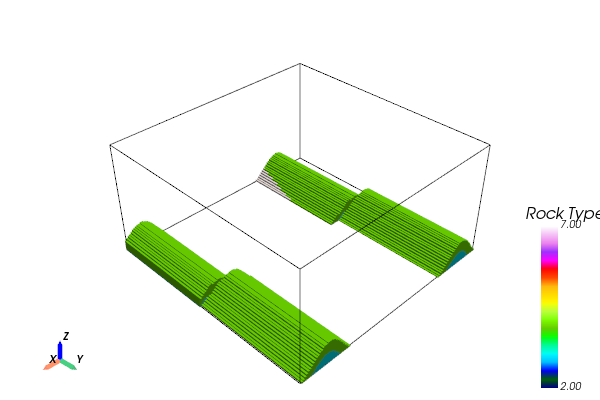

In [3]:
# Bedrock forms the basement layer of the model.  
bedrock = geo.Bedrock(base=-15, value=1)

# Sedimentation is a layer of sedimentary rock that is deposited until reaching a fixed height.
# Sedimentation takes a list of values that represent different types of sedimentary rocks.
# The thickness of eac
sediment0 = geo.Sedimentation(value_list=range(1, 5), 
                              thickness_list= [2,2,2,2],
                              base = -15
                              )

dike  = geo.Dike(strike=10, dip=80, width=3, origin=(-6, 8, 0), value=7)
tilt = geo.Tilt(strike=0, dip=-10, origin=(0,0,0))
fold = geo.Fold(strike=0, dip=80, rake=0, origin=(0, 0, 0), amplitude=4, period=30, shape=.3)
fault = geo.Fault(strike=90, dip=80, rake=5, amplitude=1.2, origin=(0, 0, 0))
shift = geo.Shift((0,0,-4))

history = [bedrock, sediment0, dike, fold, fault, shift]

model.clear_history()
model.add_history(history)
model.compute_model()
p = geovis.volview(model)
p.window_size = window_size
p.show(jupyter_backend='static')



### Testing waveform generator
Accepts number of harmonics to include and a smoothness factor

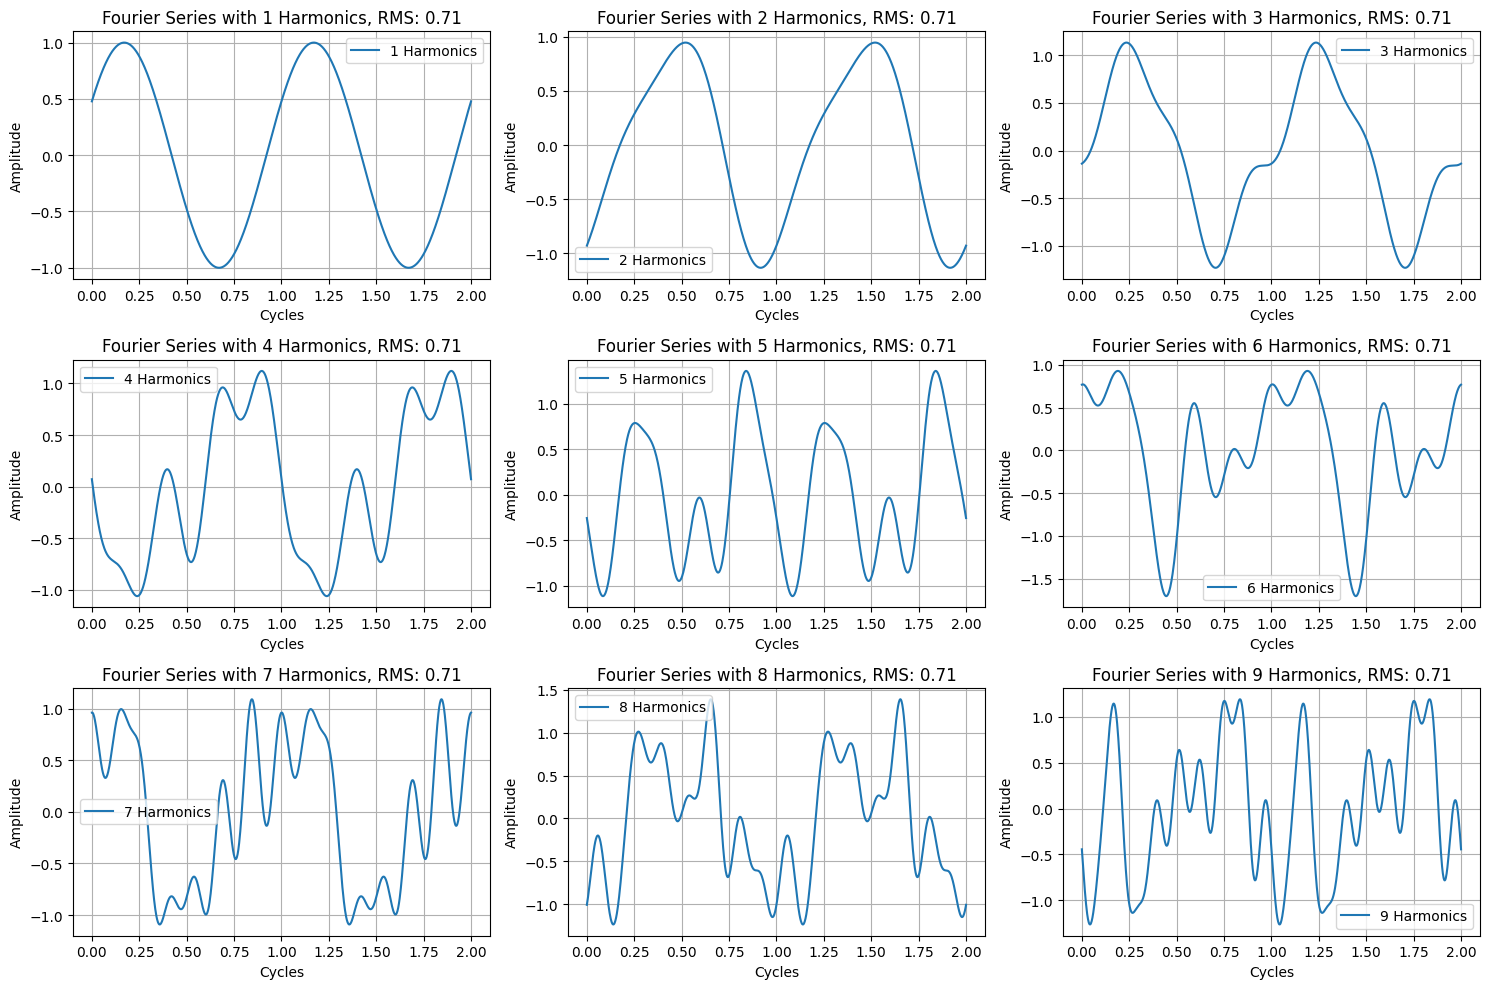

In [4]:
from scipy.integrate import quad

# Create a figure with a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10)) 

smooth = .6
# Generate waveforms for 1 to 9 harmonics
for i in range(1, 10):
    wave_func = rv.FourierWaveGenerator(num_harmonics=i, smoothness=smooth).generate()
    
    # Numerically integrate the function from 0 to 1
    def wave_square(x):
        return wave_func(x)**2
    integral_result, _ = quad(wave_square, 0, 1, limit =100)
    
    # Create an array of x-values, here corrected to show more cycles
    x = np.linspace(0, 2, 1000)  # Adjust x values to display enough cycles
    y = wave_func(x)  # Evaluate the wave function

    # Find the appropriate subplot (row and column)
    ax = axes[(i-1)//3, (i-1)%3]
    ax.plot(x, y, label=f'{i} Harmonics')
    ax.set_title(f'Fourier Series with {i} Harmonics, RMS: {np.sqrt(integral_result):.2f}')
    ax.set_xlabel('Cycles')
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)

# Adjust layout so plots do not overlap
plt.tight_layout()
plt.show()


### Testing feature origin generator

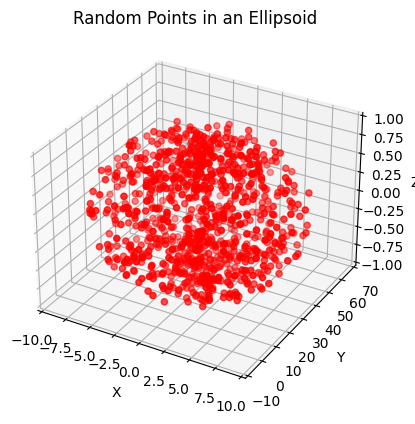

In [5]:
# Define bounds for the ellipsoid
bounds = ((-10, 10), (-10, 70), (-1, 1))

# Generate multiple points
num_points = 1000
points = np.array([rv.random_point_in_ellipsoid(bounds) for _ in range(num_points)])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o')

# Setting equal scaling
ax.set_xlim([bounds[0][0], bounds[0][1]])
ax.set_ylim([bounds[1][0], bounds[1][1]])
ax.set_zlim([bounds[2][0], bounds[2][1]])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Random Points in an Ellipsoid')
plt.show()



Geological History:
1: Bedrock: with z <= 5.0 and value 1.0


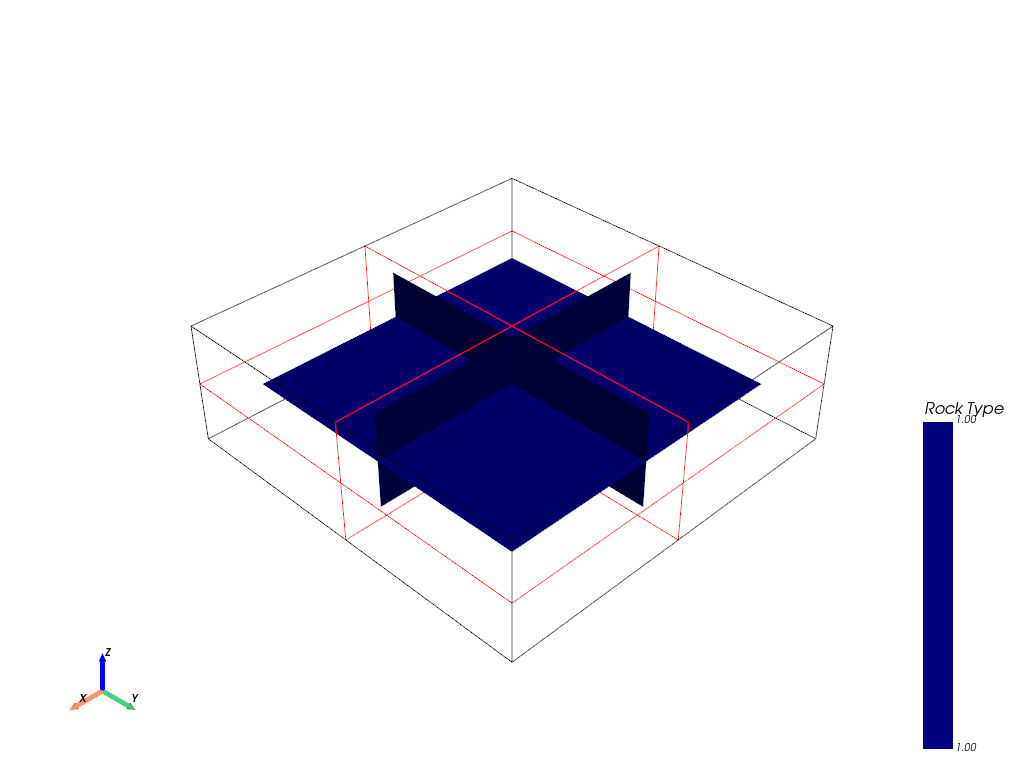

In [6]:

model = geo.GeoModel()
bedrock = geo.Bedrock(base=5, value=1)

model.add_history([bedrock])
print(model.get_history_string())
model.compute_model()
len(model.data)
p = geovis.orthsliceview(model).show(jupyter_backend='static')

In [7]:
import structgeo.model as geo
layer_builder = rv.SedimentBuilder(2, 7.5, min_layers= 3, max_layers=10)
layer_builder.get_layers()

([2, 3, 4, 5], array([1.7650588 , 1.0180611 , 1.96099866, 2.75588144]))

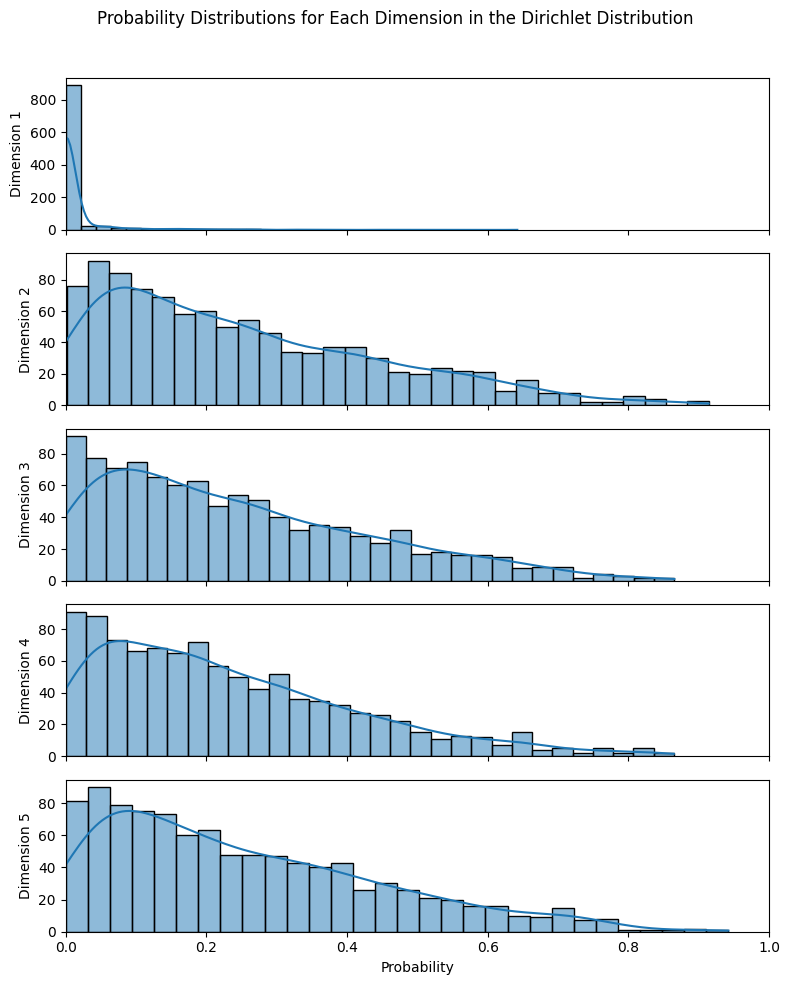

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the number of dimensions
n_dim = 5
bias_factor = 0.05
alpha = 1

alphas = np.ones(n_dim) * alpha
alphas[0] *= bias_factor


# Create the transition probabilities
probabilities = np.random.dirichlet(alphas)

# Generate random samples
n_samples = 1000
samples = np.random.dirichlet(alphas, n_samples)

# Plot the probability distributions for each dimension
fig, axes = plt.subplots(n_dim, 1, figsize=(8, 2 * n_dim), sharex=True)

for i in range(n_dim):
    sns.histplot(samples[:, i], kde=True, ax=axes[i], bins=30)
    axes[i].set_ylabel(f'Dimension {i+1}')
    axes[i].set_xlim(0, 1)
    axes[i].set_ylim(0, None)

axes[-1].set_xlabel('Probability')
plt.suptitle('Probability Distributions for Each Dimension in the Dirichlet Distribution')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



### Log normal visualizaiton

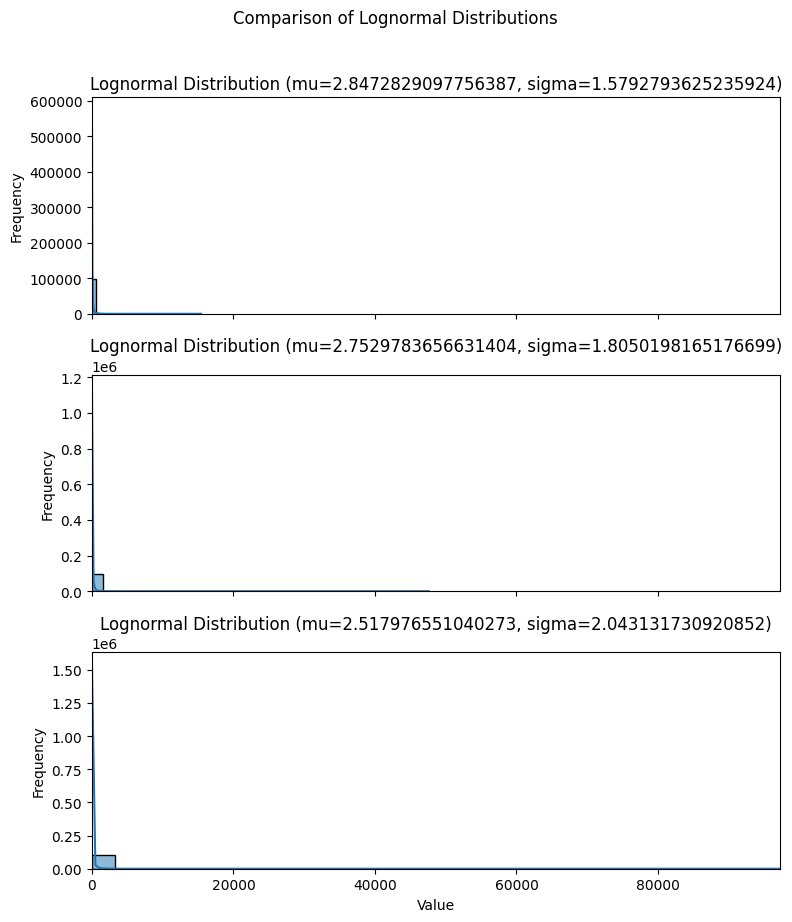

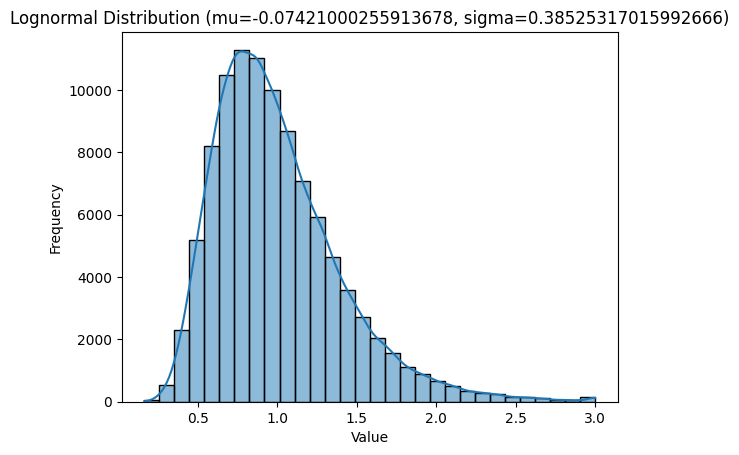

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameters for the lognormal distributions
means = [60,80,100]
stds = [200,400,800]
n_samples = 100000

# Plot the lognormal distributions
fig, ax = plt.subplots(len(means), 1, figsize=(8, len(stds) * 3), sharex=True)

for i, (mean, std) in enumerate(zip(means, stds)):
    # Generate lognormal samples
    mu, sigma = rv.log_normal_params(mean, std)
    samples = np.random.lognormal(mu, sigma, size=n_samples)
    
    # Plot the distribution
    sns.histplot(samples, kde=True, ax=ax[i], bins=30)
    
    # Set titles and labels
    ax[i].set_title(f'Lognormal Distribution (mu={mu}, sigma={sigma})')
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlim(0, np.max(samples))
    ax[i].set_ylim(0, None)

# Set the x-axis label for the last subplot
ax[-1].set_xlabel('Value')

plt.suptitle('Comparison of Lognormal Distributions', y=1.02)
plt.tight_layout()
# plt.show()

fig = plt.figure()
# Also plot a single lognormal distribution
mu, sigma = rv.log_normal_params(mean = 1, std_dev=.4)

samples = np.random.lognormal(mu, sigma, size=n_samples)
samples = np.clip(samples, 0, 3)
sns.histplot(samples, kde=True, bins=30)
plt.title(f'Lognormal Distribution (mu={mu}, sigma={sigma})')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()